#0. Environment Setting

In [ ]:
import pandas as pd
import numpy as np
import chardet
import glob
import os
from scipy import stats

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.patches as patches


In [ ]:
!pip install hmmlearn
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 5.2 MB/s eta 0:00:00


#5. Case Study for HoYoMix

###5.1 Data Preprocessing

In [ ]:
hmm_result = pd.read_csv("/content/HMM_Labeled_Lifecycle.csv")
hmm_result['Week'] = pd.to_datetime(hmm_result['Week'])
hmm_result['State'] = hmm_result['State'].astype(str)

In [ ]:
genshin_updates = pd.read_excel("/content/genshin_calender.xlsx")
honkai_updates = pd.read_excel("/content/honkai_calender.xlsx")

# game name
genshin_updates['Game'] = "Genshin Impact"
honkai_updates['Game'] = "Honkai: Star Rail"

# to datetime
genshin_updates['Release_Date'] = pd.to_datetime(genshin_updates['Release_Date'])
honkai_updates['Release_Date'] = pd.to_datetime(honkai_updates['Release_Date'])

# merge
updates_df = pd.concat([genshin_updates, honkai_updates], ignore_index=True)

# to
updates_df['Week'] = updates_df['Release_Date'].dt.to_period('W').apply(lambda r: r.start_time)

### 5.2 Visualization

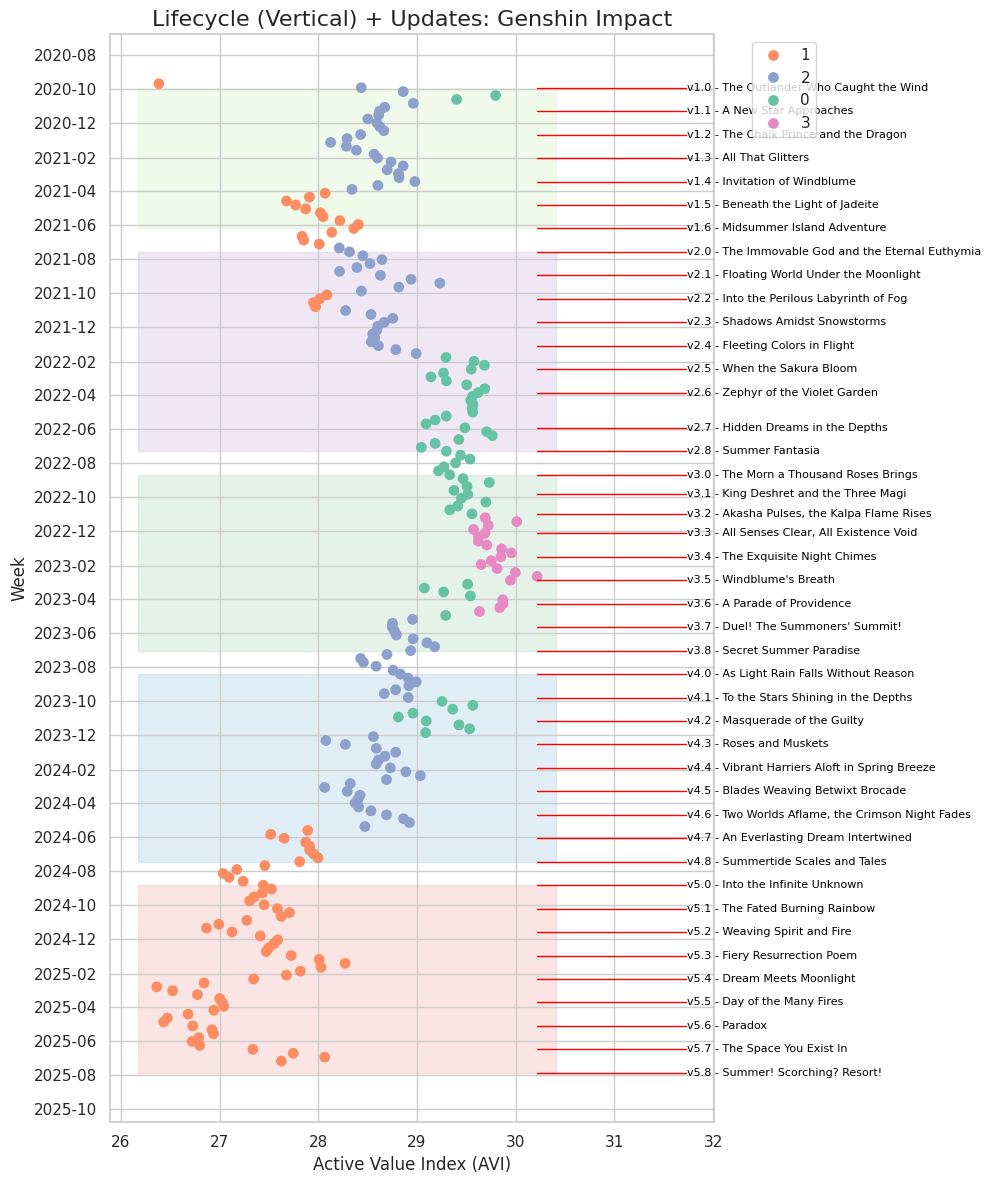

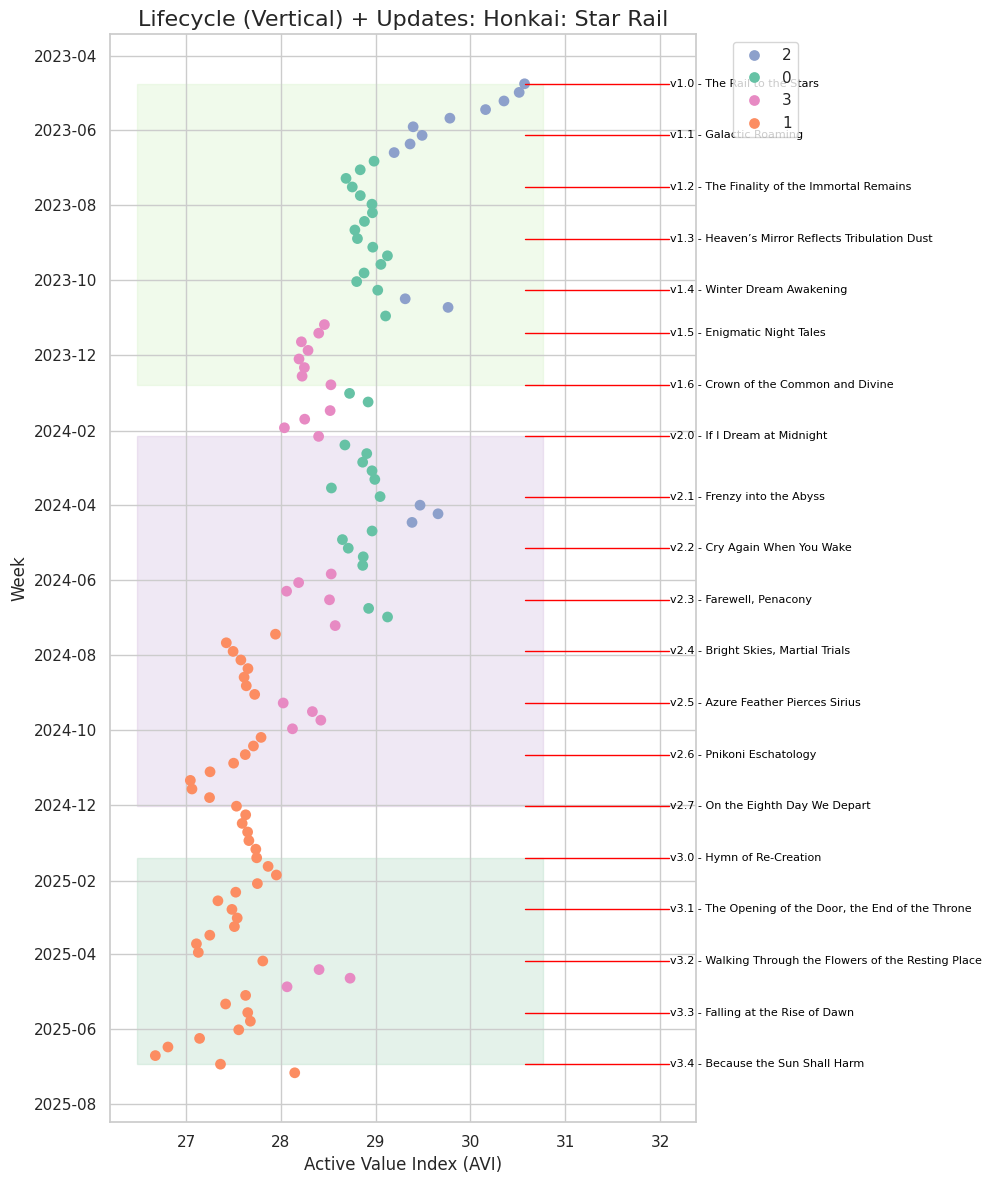

In [ ]:
#style setting
state_palette = {
    "0": "#66c2a5",  # green
    "1": "#fc8d62",  # orange
    "2": "#8da0cb",  # blue
    "3": "#e78ac3"   # pink
}

sns.set(style='whitegrid')

for game in ["Genshin Impact", "Honkai: Star Rail"]:
    subset = hmm_result[hmm_result['Name'] == game].copy()
    game_updates = updates_df[updates_df['Game'] == game].copy()

    plt.figure(figsize=(10, 12))

    # HMM scatters
    sns.scatterplot(
        data=subset,
        x='AVI',
        y='Week',
        hue='State',
        palette=state_palette,
        s=60,
        edgecolor=None,
        linewidth=0,
        legend='brief'
    )

    # background color
    ax = plt.gca()
    ymin, ymax = ax.get_ylim()

    # library for version color
    version_bg_colors = {
        "1": "#d0f0c0",  # light green
        "2": "#cdb4db",  # pruple
        "3": "#a8d5ba",  # green
        "4": "#9ac6e0",  # blue
        "5": "#f4a6a6"   # red
    }

    # group and color by version
    for prefix, color in version_bg_colors.items():
        # version number
        filtered = game_updates[game_updates['Version'].astype(str).str.startswith(prefix)]
        if filtered.empty:
            continue
        # apply version update to week date
        min_week = filtered['Week'].min()
        max_week = filtered['Week'].max()

        # draw color shape
        rect = patches.Rectangle(
            (ax.get_xlim()[0], max_week),
            width=ax.get_xlim()[1] - ax.get_xlim()[0],
            height=min_week - max_week,
            color=color,
            alpha=0.3,
            zorder=0
        )
        ax.add_patch(rect)

    # redline for version update
    max_avi = subset['AVI'].max()
    line_x_start = max_avi
    line_x_end = max_avi * 1.05

    for _, row in game_updates.iterrows():
        # draw line
        plt.plot([line_x_start, line_x_end], [row['Week'], row['Week']], color='red', linewidth=1)

        # add text
        plt.text(
            line_x_end + 0.01,  # location for text
            row['Week'],
            f"v{row['Version']} - {row['Title']}",
            va='center',
            fontsize=8,
            color='black'
        )

    # xtick setting
    plt.gca().yaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().invert_yaxis()
    plt.xticks(rotation=0)

    plt.title(f'Lifecycle (Vertical) + Updates: {game}', fontsize=16)
    plt.xlabel('Active Value Index (AVI)')
    plt.ylabel('Week')

    # labels format
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
